<img src="brain.jpeg" width="500"/>

# Stroke Prediciton Analysis
Author: Volha Puzikava
***

## Overview
Every 40 seconds, someone in the United States has a stroke. Every 3.5 minutes, someone dies of stroke. Every year, more than 795,000 people in the United States have a stroke. According to the World Health Organization (WHO), stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. Moreover, stroke is a leading cause of serious long-term disability.

This project tends to predict whether a patient is more likely to get a stroke during their lifetime and thus, helps to reduce stroke occurence and prevent the illness before it happens. 
***

### Business Problem
The World Health Organization asked to analyze the stroke dataset and provide information about what parameters likely increase the occurence of stroke in people, so the people with the higher chance of getting stroke can be monitored more often in order to prevent the illness before it strikes. The main purpose of the analysis was to build different machine learning algorithms and choose the one that has the highest performance rate predicting the stroke occurence.
***

### Data Understanding
The data for the analysis was taken from [kaggle website](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv). The data provided 11 clinical features for predicting stroke effect: gender and age of the patients, their marital status, work type, residence type, smoking status, the precense of hypertension and heart disease, average glucose level and body mass index. The dataset contained information about 5,110 patients.
***

In [1]:
# Load the dataset and inspect the head to make sure everything loaded correctly
import pandas as pd
df = pd.read_csv('Data/Stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


***

### Data Preparation and Exploration
The first step was to check how imbalanced the dataset was. Since the column "stroke" served as the indicator of weather or not a patient had a stroke, the distribution of values in that column was calculated. It turned out that the dataset was imbalanced: 95% of people did not have a stroke, while only 5% had. 

The dataset was then checked for the presence of missing values. They were present only in "bmi" column and were replaced with the column's mean value.

In [2]:
# Check the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
# Check for class imbalance
print("Raw Counts:")
print(df['stroke'].value_counts())
print()
print('Percentages:')
print(df['stroke'].value_counts(normalize=True))

Raw Counts:
0    4861
1     249
Name: stroke, dtype: int64

Percentages:
0    0.951272
1    0.048728
Name: stroke, dtype: float64


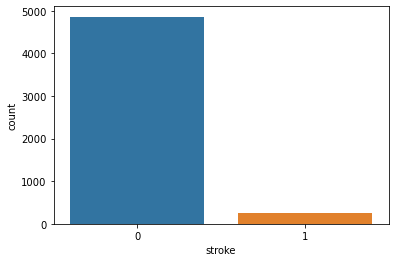

In [4]:
# Plot the distribution of values in column 'stroke'
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.countplot(df['stroke']);

In [5]:
# Check for missing values in the dataset
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# Fill in the missing values in 'bmi' column with mean value
df['bmi'] = df['bmi'].fillna(df.bmi.mean())
df['bmi'] = df['bmi'].round(decimals=1)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

The distribution of stroke occurence was then checked among the numerical features of the dataset. It was found out that the average age of people with stroke is around 67 years, those people are more likely to have hypertension and heart disease and their glucose level is much higher than in people without a stroke. Also, body mass index turned out to be not of a much influence. The pairplot was then used to visualize the relationship betweeen the variables.

In [7]:
# Look at the distibution of stroke among numerical features
df.groupby('stroke').mean()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,,
0,36487.236371,41.971545,0.088871,0.047110,104.795513,28.825612
1,37115.068273,67.728193,0.265060,0.188755,132.544739,30.218876


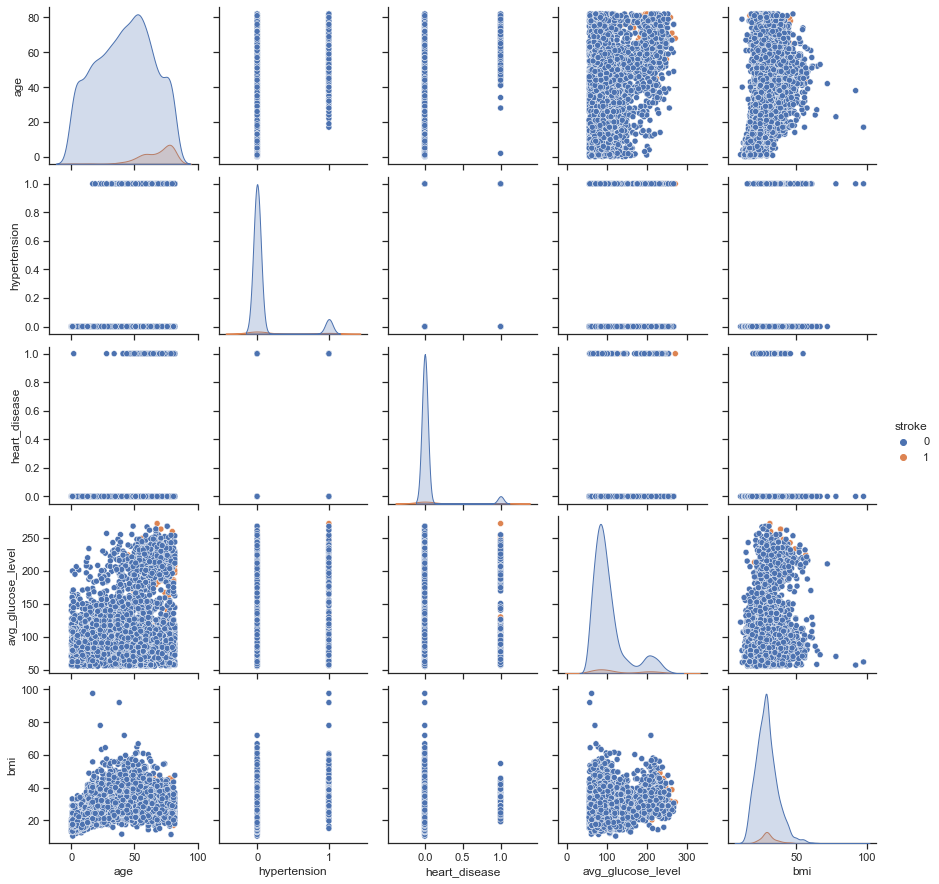

In [8]:
# Distribution of stroke among categorical features
sns.set(style = 'ticks', color_codes=True)
sns.pairplot(data=df, hue='stroke',  
             vars=['age',
                   'hypertension',
                   'heart_disease',
                   'avg_glucose_level',
                   'bmi']);

The stroke incidences were also compared by gender, marital status, work type, residence type and smoking status. It turned out that people who are married, self-employed and formely smokers are more likely to develop stroke in their lifetime. Gender and residence type do not influence much on the occurence of the illness.

Percentage of Stroke Occurence Based on Gender:
gender
Female    4.709419
Male      5.106383
Other     0.000000
Name: stroke, dtype: float64



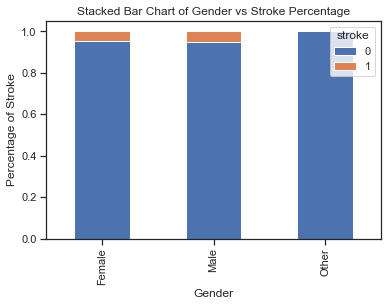

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Distribution of stroke based on gender
print("Percentage of Stroke Occurence Based on Gender:")
print(df.groupby('gender')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.gender, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Gender vs Stroke Percentage')
plt.xlabel('Gender')
plt.ylabel('Percentage of Stroke')
plt.savefig('gender_vs_stroke')

Percentage of Stroke Occurence Based on Marital Status:
ever_married
No     1.650541
Yes    6.561288
Name: stroke, dtype: float64



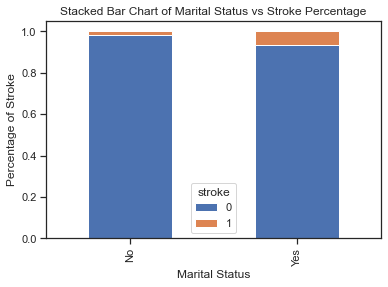

In [10]:
# Distribution of stroke based in marital status
print("Percentage of Stroke Occurence Based on Marital Status:")
print(df.groupby('ever_married')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.ever_married, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Stroke Percentage')
plt.xlabel('Marital Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('marriage_vs_stroke')

Percentage of Stroke Occurence Based on Work Type:
work_type
Govt_job         5.022831
Never_worked     0.000000
Private          5.094017
Self-employed    7.936508
children         0.291121
Name: stroke, dtype: float64



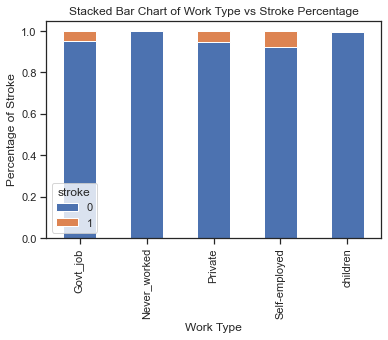

In [11]:
# Distribution of stroke based on work type
print("Percentage of Stroke Occurence Based on Work Type:")
print(df.groupby('work_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.work_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Work Type vs Stroke Percentage')
plt.xlabel('Work Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('work_vs_stroke')

Percentage of Stroke Occurence Based on Residence Type:
Residence_type
Rural    4.534606
Urban    5.200308
Name: stroke, dtype: float64



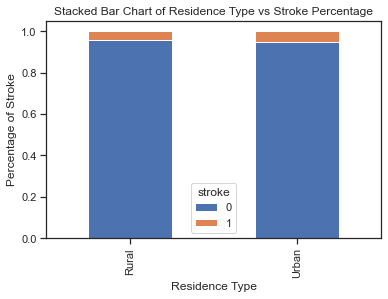

In [12]:
# Distribution of stroke based on residence type
print("Percentage of Stroke Occurence Based on Residence Type:")
print(df.groupby('Residence_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.Residence_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Residence Type vs Stroke Percentage')
plt.xlabel('Residence Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('residence_vs_stroke')

Percentage of Stroke Occurence Based on Smoking Status:
smoking_status
Unknown            3.044041
formerly smoked    7.909605
never smoked       4.756871
smokes             5.323194
Name: stroke, dtype: float64



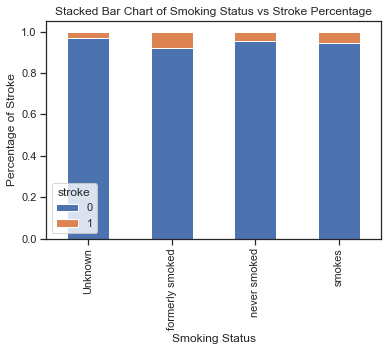

In [13]:
# Distribution of stroke based on smoking status
print("Percentage of Stroke Occurence Based on Smoking Status:")
print(df.groupby('smoking_status')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.smoking_status, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Smoking Status vs Stroke Percentage')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('smoking_vs_stroke')

In order to be used in a model, all categorical variables ("gender", "ever_married", "Residence_type", "work_type" and "smoking_status") had to be transformed. The first three mentioned columns had the values replaced to numerical ones, while the remaining two columns used dummy variables.

In [14]:
# Transform the categorical variables into numerical 
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1, 'Other': 2}).astype('int8')
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1}).astype('int8')
df['Residence_type'] = df['Residence_type'].replace({'Urban': 0, 'Rural': 1}).astype('int8')

In [15]:
# Create dummy variables
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,0,228.69,36.6,1,0,0,1,0,0,0,1,0,0
1,51676,0,61.0,0,0,1,1,202.21,28.9,1,0,0,0,1,0,0,0,1,0
2,31112,1,80.0,0,1,1,1,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,60182,0,49.0,0,0,1,0,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,1665,0,79.0,1,0,1,1,174.12,24.0,1,0,0,0,1,0,0,0,1,0


It was also important to see if the predictive features would result in multicollinearity in the final model. With that in mind, pearson correlation coefficients of the predictive features were generated and visualized. According to the heatmap, the highest correlation belonged to "ever_married" and "age" (0.68). The most strongly correlated features with the target variable were "age", "hypertension", "heart_disease", "ever_married" and "avg_glucose_level".

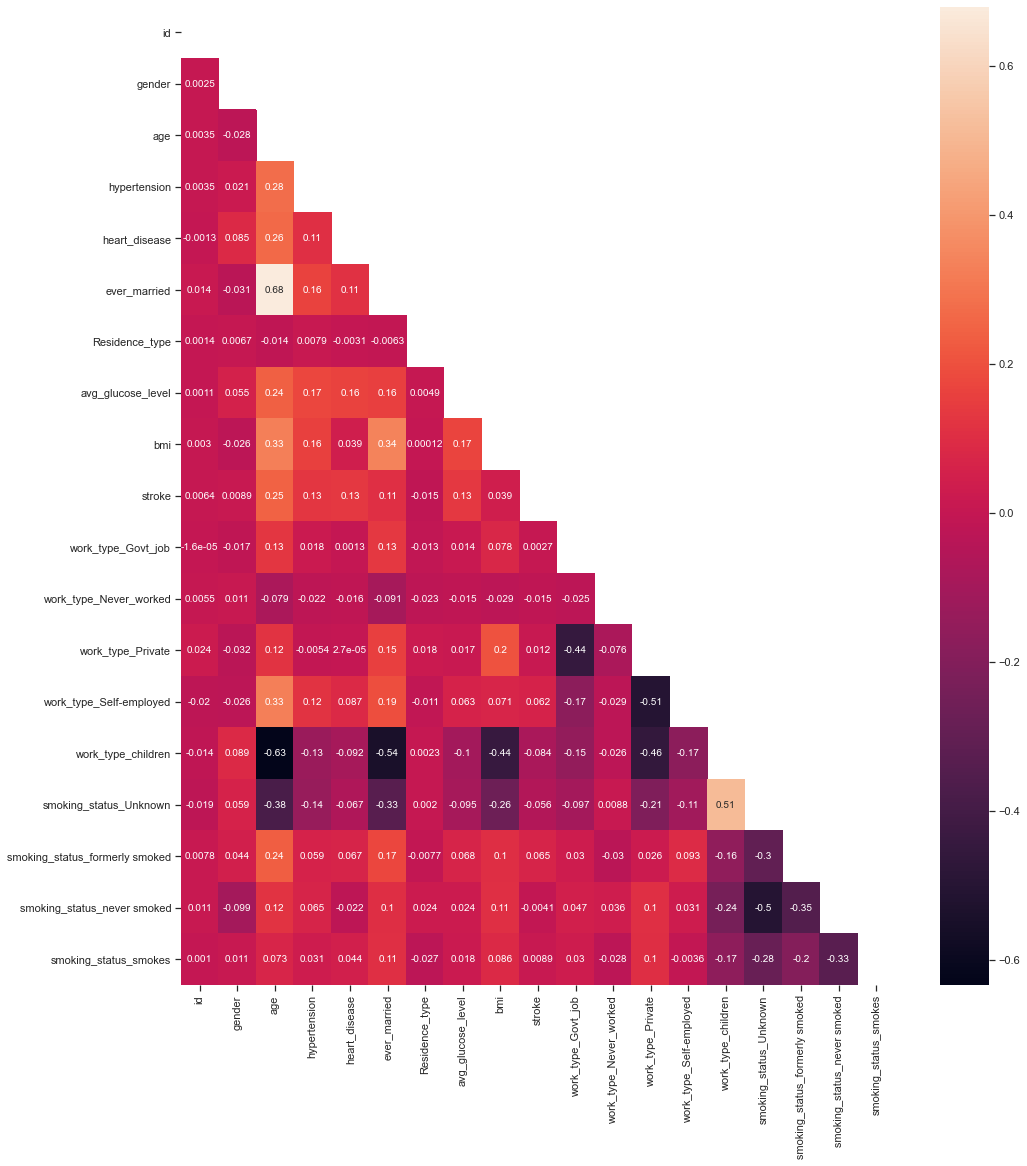

In [16]:
# Visualize the pearson correlation coefficients
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
corr = df.corr()
fig, ax = plt.subplots(figsize = (16, 18))
sns.heatmap(data = corr, 
            mask = np.triu(np.ones_like(corr, dtype = bool)), 
            ax = ax, 
            annot = True);

***

### Data Modeling
In order to build any ML model, a train-test split should be performed. The prediction target for this analysis was the column "stroke", so the data was separated into a train set and test set accordingly. The "id" column was dropped since it represented a unique identifier, not an actual numeric feature.

The class imbalance in the training and test set was then found and SMOTE class was used in order to improve the models' performance on the minority class.

In [17]:
# Split the outcome and predictor variables
y = df['stroke']
X = df.drop(columns=['id', 'stroke'], axis=1)

In [18]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

0    3645
1     187
Name: stroke, dtype: int64 

 0    1216
1      62
Name: stroke, dtype: int64


In [202]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(random_state=42, categorical_features=[1, 5, 6, 7, 10])
X_res, y_res = sm.fit_resample(X_train, y_train)
print(y_res.value_counts())

1    3645
0    3645
Name: stroke, dtype: int64


In [19]:
# Use SMOTE class to improve the model's performance on the minority class
from imblearn.over_sampling import SMOTE
smote = SMOTE()

# Preview the synthetic sample class distribution
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(y_train_resampled.value_counts())

1    3645
0    3645
Name: stroke, dtype: int64


Since the World Health Organization really cares about avoiding 'false negatives' more than avoiding 'false positives' (it is a crime to say that a person will not have a stroke, and then he/she will develop it, than predict that the person will have a stroke and he/she will not actually have it), higher recall score and lower number of false negatives will be the metrics the ML models will be evaluated upon. The model with the highest recall will be chosen for the prediction.

Different machine learning algorithms will be build in the following way:

- the baseline model will be build and evaluated;
- one or more hyperparameters will be tuned to find if the model will perform any better;
- the optimized model will be run and checked for any improvements in the performance;
- the model with the highest recall score for each algorithm type will be chosen for further analysis.

**Logistic Regression Models**

In [203]:
# Build a baseline model
from sklearn.linear_model import LogisticRegression

logreg_baseline = LogisticRegression(random_state=42)
logreg_baseline.fit(X_res, y_res)

LogisticRegression(random_state=42)

In [204]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Write the function that evaluates models on test sets
def print_metrics(labels, preds):
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [205]:
# Evaluate baseline model performance
preds = logreg_baseline.predict(X_test)
print("Logistic Regression Baseline Model:")
print_metrics(y_test, preds)

Logistic Regression Baseline Model:
Accuracy Score: 0.7323943661971831
Precision Score: 0.12365591397849462
Recall Score: 0.7419354838709677
F1 Score: 0.21198156682027652


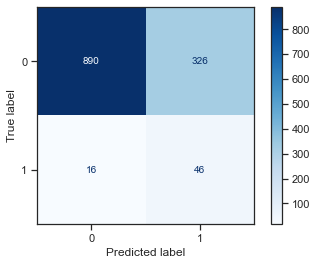

In [206]:
# Plot confusion matrix of the baseline model
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [207]:
# Print the classification report
from sklearn.metrics import classification_report

print('Classification Report of Logistic Regression Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Logistic Regression Baseline Model:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1216
           1       0.12      0.74      0.21        62

    accuracy                           0.73      1278
   macro avg       0.55      0.74      0.53      1278
weighted avg       0.94      0.73      0.81      1278



The logistic regression baseline model with default parameters has recall of 34%, meaning that if a person belongs to class 1 (having a stroke), there is about 34% chance that the model will correctly label this person as class 1. The number of false negatives was equal to 41. The accuracy of the model constituted 91%, meaning that the model correctly identifies if a person will have a stroke about 91% of the time.

The hyperparameters were tuned to check if the model will perform any better.

In [208]:
# Use the GridSerch to find better hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

logreg_tuned = LogisticRegression(random_state=42)
param_grid = {'penalty' : ['l1', 'l2', 'elasticnet'],
              'solver' : ['liblinear', 'saga']}
    
grid_search = GridSearchCV(estimator = logreg_tuned,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_res, y_res)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']})

In [209]:
# Print the hyperparameters
grid_search.best_params_

{'penalty': 'l2', 'solver': 'liblinear'}

In [210]:
# Build a model with mentioned hyperparameters 
logreg_tuned = LogisticRegression(random_state=42,
                                  penalty='l2',
                                  solver='liblinear')
logreg_tuned.fit(X_res, y_res)

LogisticRegression(random_state=42, solver='liblinear')

In [211]:
# Evaluate the model's performance
preds = logreg_tuned.predict(X_test)
print("Logistic Regression Tuned Model:")
print_metrics(y_test, preds)

Logistic Regression Tuned Model:
Accuracy Score: 0.7300469483568075
Precision Score: 0.1246684350132626
Recall Score: 0.7580645161290323
F1 Score: 0.21412300683371296


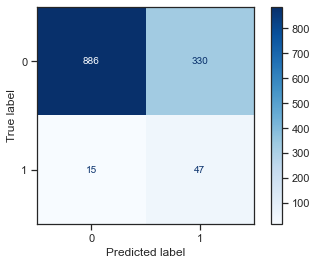

In [212]:
# Plot the confusion matrix 
plot_confusion_matrix(logreg_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [213]:
# Print classification report
print('Classification Report of Logistic Regression Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Logistic Regression Tuned Model:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1216
           1       0.12      0.76      0.21        62

    accuracy                           0.73      1278
   macro avg       0.55      0.74      0.53      1278
weighted avg       0.94      0.73      0.81      1278



The logistic regression tuned model performed worse: the recall score got smaller (29%), while the number of false negatives got a little higher (44).The logistic regression baseline model with default parameters was chosen for future analysis.

**Decision Tree Models**

In [31]:
# Build a baseline model 
from sklearn.tree import DecisionTreeClassifier

dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [32]:
# Evaluate the model's performance
preds = dt_baseline.predict(X_test)
print("Decision Tree Baseline Model:")
print_metrics(y_test, preds)

Decision Tree Baseline Model:
Accuracy Score: 0.8935837245696401
Precision Score: 0.11458333333333333
Recall Score: 0.1774193548387097
F1 Score: 0.13924050632911392


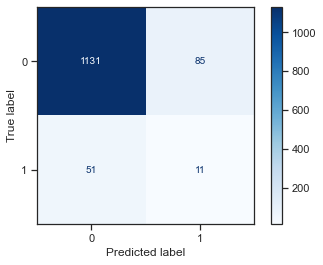

In [33]:
# Plot the confusion matrix
plot_confusion_matrix(dt_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [34]:
# Print classification report
print('Classification Report of Decision Tree Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Decision Tree Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1216
           1       0.11      0.18      0.14        62

    accuracy                           0.89      1278
   macro avg       0.54      0.55      0.54      1278
weighted avg       0.92      0.89      0.90      1278



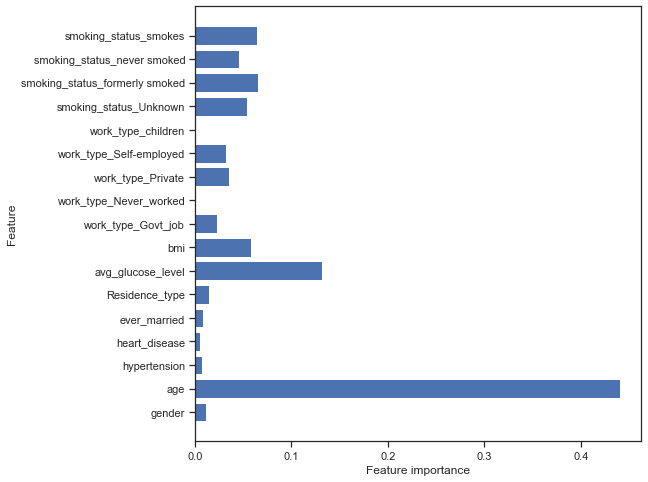

In [35]:
# Examine how important each feature ends up in the model
def plot_feature_importances(model):
    n_features = X_train_resampled.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_resampled.columns.values)
    plt.xlabel("Feature importance")
    plt.ylabel('Feature')
    
plot_feature_importances(dt_baseline)

The decision tree baseline model had a recall of 18%, which was less than the logistic regression baseline model. The number of false negatives got a little higher and became equal to 51. The model used all the features except "work_type_Never_worked" and "work_type_children" with the most important being "age" and "avg_glucose_level". The model was then optimized to check if better recall could be achieved.

In [36]:
# Write the function that calculates and returns the recall score between true and predicted valueas
def performance(y_true, y_predict):
    recall = recall_score(y_true, y_predict)
    return [recall]

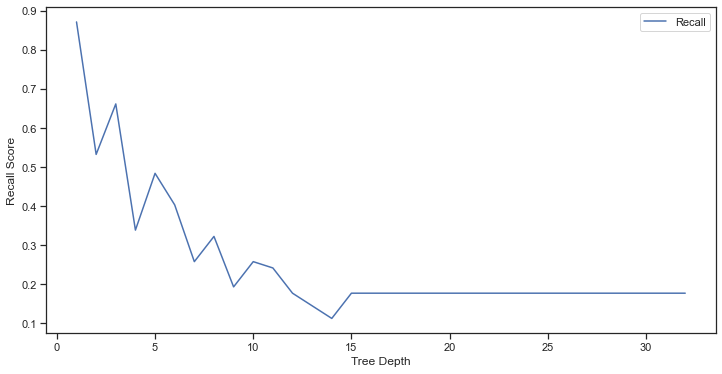

In [37]:
# Find the best tree depth using the range: 1-30
max_depths = np.linspace(1, 32, 32, endpoint=True)
recall_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(max_depths, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Tree Depth")
plt.legend()
plt.show()

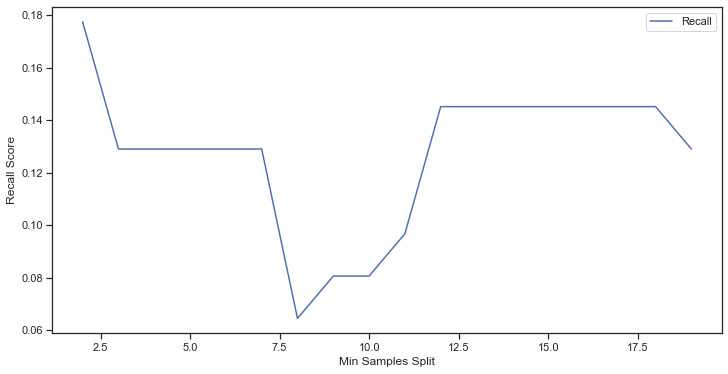

In [38]:
# Find the best min samples split
min_samples_splits = np.arange(2, 20)
recall_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(
        min_samples_split=int(min_samples_split),
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Min Samples Split")
plt.legend()
plt.show()

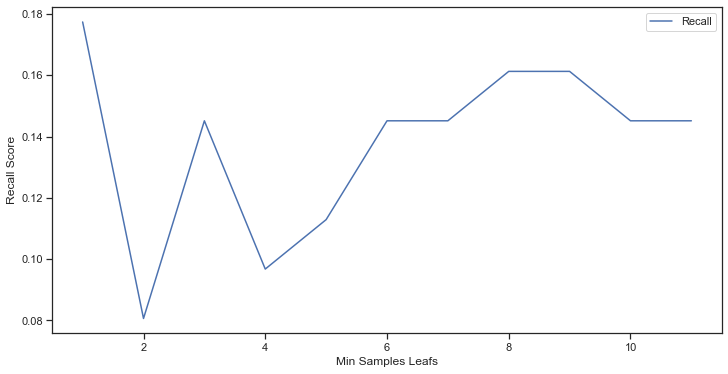

In [39]:
# Find the best min samples leafs
min_samples_leafs = np.arange(1, 12)
recall_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(
        min_samples_leaf=int(min_samples_leaf),
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_leafs, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Min Samples Leafs")
plt.legend()
plt.show()

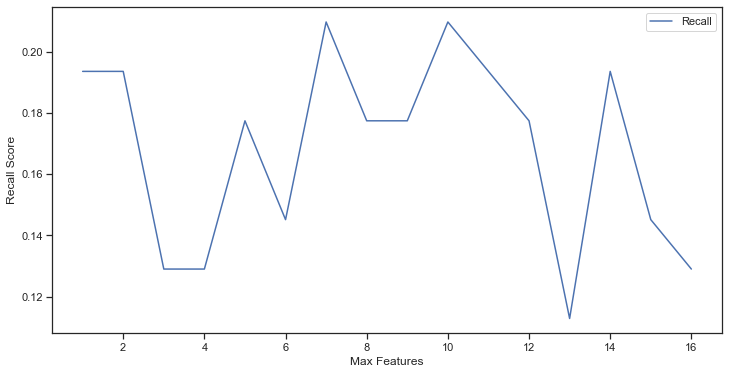

In [40]:
# Find best max features
max_features = list(range(1, X_train_resampled.shape[1]))
recall_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(
        max_features=max_feature,
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(max_features, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Max Features")
plt.legend()
plt.show()

According to the above graphs, the best tree depth is equal to 3, the best min samples split to 15, the best min samples leafs to 9 and the best max feature parameter to 10. The optimized model was then run and evaluated.

In [41]:
# Run an optimized model with the found values and find the average cross-validated log loss
dt_tuned = DecisionTreeClassifier(
    random_state=42,
    max_depth=3,
    min_samples_split=15,
    min_samples_leaf=9,
    max_features=10)
dt_tuned.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=3, max_features=10, min_samples_leaf=9,
                       min_samples_split=15, random_state=42)

In [42]:
# Check the model's performance
preds = dt_tuned.predict(X_test)
print("Decision Tree Tuned Model:")
print_metrics(y_test, preds)

Decision Tree Tuned Model:
Accuracy Score: 0.6971830985915493
Precision Score: 0.11031175059952038
Recall Score: 0.7419354838709677
F1 Score: 0.19206680584551147


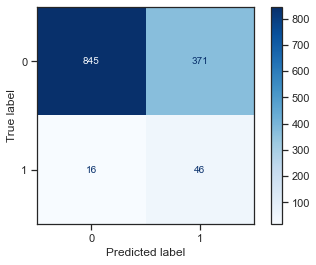

In [43]:
# Plot the confusion matrix
plot_confusion_matrix(dt_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [44]:
# Print classification report
print('Classification Report of Decision Tree Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Decision Tree Tuned Model:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1216
           1       0.11      0.74      0.19        62

    accuracy                           0.70      1278
   macro avg       0.55      0.72      0.50      1278
weighted avg       0.94      0.70      0.78      1278



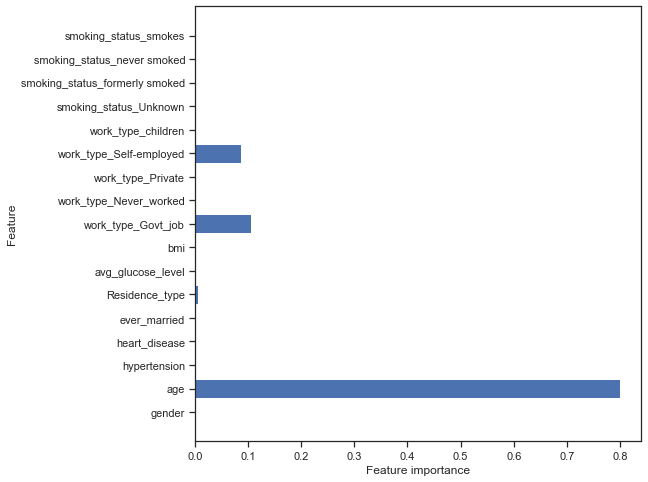

In [45]:
# Examine how important each feature is in the model
plot_feature_importances(dt_tuned)

The decision tree tuned model performed much better than the previous models. It showed the recall of 74% with false negatives being equal to 16. The model considered "age", "work_type_Self-employed", "work_type_Govt_job" as the most important features. The model was chosen for future analysis.

**Bagged Trees Models**

In [46]:
# Build a baseline model with Bagging and find the average cross-validated log loss
# Set the n_estimators parameter to 100
from sklearn.ensemble import BaggingClassifier

bagged_tree_baseline = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100)
bagged_tree_baseline.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=100)

In [47]:
# Evaluate the performance of the model
preds = bagged_tree_baseline.predict(X_test)
print("Bagged Tree Baseline Model:")
print_metrics(y_test, preds)

Bagged Tree Baseline Model:
Accuracy Score: 0.9334898278560251
Precision Score: 0.15151515151515152
Recall Score: 0.08064516129032258
F1 Score: 0.10526315789473684


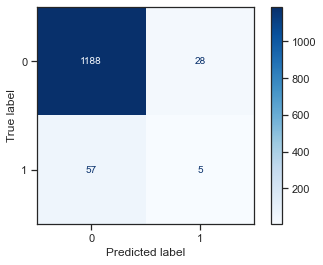

In [48]:
# Plot the confusion matrix
plot_confusion_matrix(bagged_tree_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [49]:
# Print classification report
print('Classification Report of Bagged Tree Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Bagged Tree Baseline Model:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1216
           1       0.15      0.08      0.11        62

    accuracy                           0.93      1278
   macro avg       0.55      0.53      0.54      1278
weighted avg       0.92      0.93      0.92      1278



The bagged tree baseline model didn't perform well enough. The recall score was equal to only 8%, while the number of false negatives increased up to 57. The model got to be tuned to perform better.

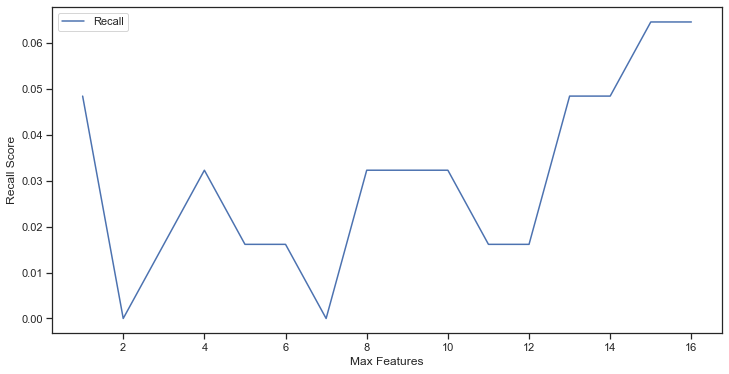

In [50]:
# Find the best value for max features
max_features = list(range(1, X_train_resampled.shape[1]))
recall_results = []
for max_feature in max_features:
    bagged = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                                    n_estimators=100,
                                    max_features=max_feature)
    bagged.fit(X_train_resampled, y_train_resampled)
    y_pred = bagged.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(max_features, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Max Features")
plt.legend()
plt.show()

According to the above graph, the best max features should be equal to 15 in order to get a higher recall value.

In [51]:
# Run the model with tuned hyperparameter
bagged_tree_tuned = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100, max_features=15)
bagged_tree_tuned.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=15, n_estimators=100)

In [52]:
# Evaluate the performance
preds = bagged_tree_tuned.predict(X_test)
print("Bagged Tree Tuned Model:")
print_metrics(y_test, preds)

Bagged Tree Tuned Model:
Accuracy Score: 0.935054773082942
Precision Score: 0.13793103448275862
Recall Score: 0.06451612903225806
F1 Score: 0.08791208791208792


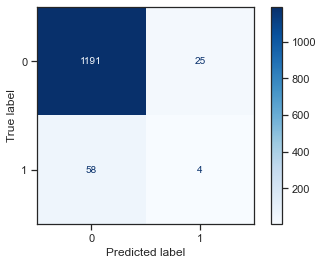

In [53]:
# Plot the confusion matrix
plot_confusion_matrix(bagged_tree_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [54]:
# Print classification report
print('Classification Report of Bagged Tree Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Bagged Tree Tuned Model:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1216
           1       0.14      0.06      0.09        62

    accuracy                           0.94      1278
   macro avg       0.55      0.52      0.53      1278
weighted avg       0.91      0.94      0.92      1278



The bagged tree tuned model performed even worse: the recall score decreased up to only 6%, while the number of false negatives got equal to 58. The bagged tree baseline model was chosen for further analysis.

**Random Forest Models**

In [55]:
# Build a baseline model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

forest_baseline = RandomForestClassifier(random_state=42)
forest_baseline.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [56]:
# Evaluate the model
preds = forest_baseline.predict(X_test)
print("Random Forest Baseline Model:")
print_metrics(y_test, preds)

Random Forest Baseline Model:
Accuracy Score: 0.9366197183098591
Precision Score: 0.08695652173913043
Recall Score: 0.03225806451612903
F1 Score: 0.047058823529411764


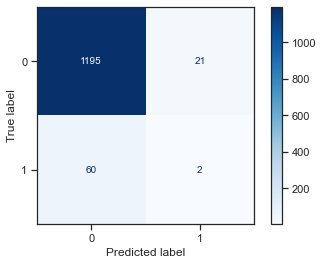

In [57]:
# Plot the confusion matrix
plot_confusion_matrix(forest_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [58]:
# Print classification report
print('Classification Report of Random Forest Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Random Forest Baseline Model:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1216
           1       0.09      0.03      0.05        62

    accuracy                           0.94      1278
   macro avg       0.52      0.51      0.51      1278
weighted avg       0.91      0.94      0.92      1278



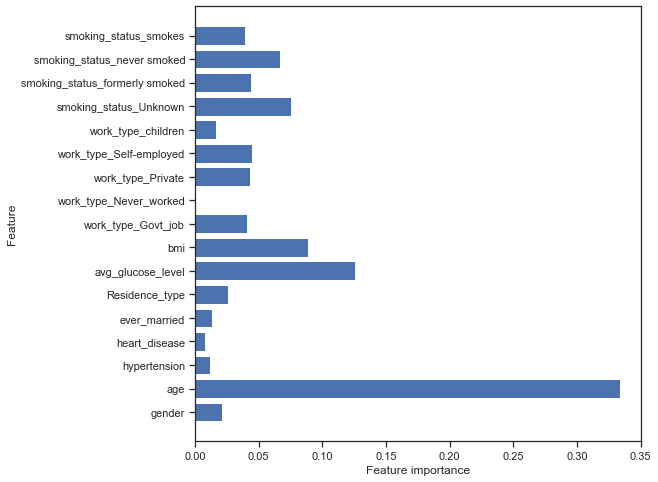

In [59]:
# Find out the importance of the features in the baseline model
plot_feature_importances(forest_baseline)

The random forest baseline model didn't perform any better: it had a low recall score (only 3%) with the high number of false negatives (60). The model gave the strongest importance to "age", "avg_glucose_level" and "bmi" columns. The model was then tuned to find if it could perform any better.

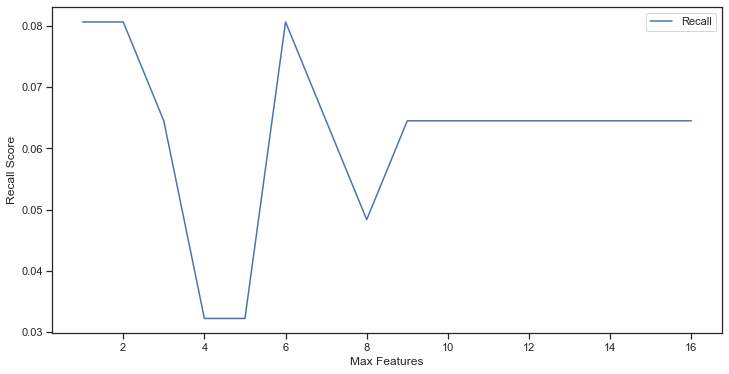

In [60]:
# Find the best value for max features
max_features = list(range(1, X_train_resampled.shape[1]))
recall_results = []
for max_feature in max_features:
    forest = RandomForestClassifier(random_state=42,
                                    max_features=max_feature)
    forest.fit(X_train_resampled, y_train_resampled)
    y_pred = forest.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(max_features, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Max Features")
plt.legend()
plt.show()

The best value of max features should be equal to 6 in order to get the higher recall value. 

In [61]:
# Run the optimized model
forest_tuned = RandomForestClassifier(random_state=42, max_features=6)
forest_tuned.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_features=6, random_state=42)

In [62]:
# Evaluate the optimized model
preds = forest_tuned.predict(X_test)
print("Random Forest Tuned Model:")
print_metrics(y_test, preds)

Random Forest Tuned Model:
Accuracy Score: 0.9389671361502347
Precision Score: 0.19230769230769232
Recall Score: 0.08064516129032258
F1 Score: 0.11363636363636363


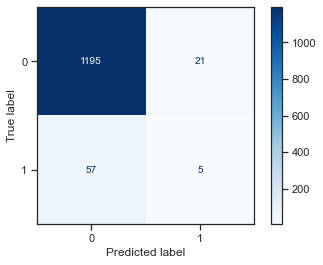

In [63]:
# Plot the confusion matrix
plot_confusion_matrix(forest_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [64]:
# Print classification report
print('Classification Report of Random Forest Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Random Forest Tuned Model:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1216
           1       0.19      0.08      0.11        62

    accuracy                           0.94      1278
   macro avg       0.57      0.53      0.54      1278
weighted avg       0.92      0.94      0.93      1278



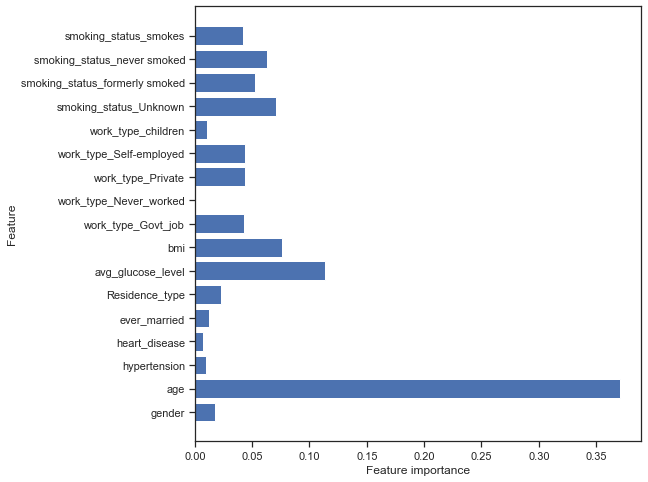

In [65]:
# Check the importance of features in the optimized model
plot_feature_importances(forest_tuned)

The recall score didn't change, and the number of false negatives stayed the same. The model considered "age" as the most important feature and didn't take into consideration "work_type_Never_worked". The random forest tuned model was chosen for further analysis.

**AdaBoost Models**

In [66]:
# Build a baseline model
from sklearn.ensemble import AdaBoostClassifier

adaboost_baseline = AdaBoostClassifier(random_state=42)
adaboost_baseline.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(random_state=42)

In [67]:
# Evaluate the model
preds = adaboost_baseline.predict(X_test)
print("AdaBoost Baseline Model:")
print_metrics(y_test, preds)

AdaBoost Baseline Model:
Accuracy Score: 0.9045383411580594
Precision Score: 0.19387755102040816
Recall Score: 0.3064516129032258
F1 Score: 0.23749999999999996


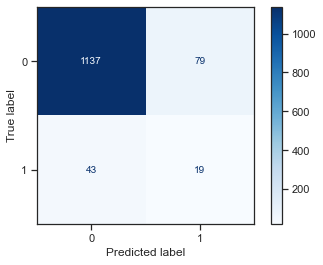

In [68]:
# Plot the confusion matrix
plot_confusion_matrix(adaboost_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [69]:
# Print classification report
print('Classification Report of Adaboost Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Adaboost Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1216
           1       0.19      0.31      0.24        62

    accuracy                           0.90      1278
   macro avg       0.58      0.62      0.59      1278
weighted avg       0.93      0.90      0.91      1278



The adaboost baseline model had a recall of 31% and 43 false negative results. The model was optimized to ccheck for better performance.

In [70]:
# Use the Grid Search to fins the best learning rate
adaboost_tuned = AdaBoostClassifier(random_state=42)
param_grid = {'learning_rate' : [0.1, 0.2]}
    
grid_search = GridSearchCV(estimator = adaboost_tuned,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.2]})

In [71]:
# Print the best parameters
grid_search.best_params_

{'learning_rate': 0.2}

In [72]:
# Run the optimized model to find the average cross-validated log loss
adaboost_tuned = AdaBoostClassifier(
    random_state=42,
    learning_rate=0.2)
adaboost_tuned.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(learning_rate=0.2, random_state=42)

In [73]:
# Evaluate the model
preds = adaboost_tuned.predict(X_test)
print("AdaBoost Tuned Model:")
print_metrics(y_test, preds)

AdaBoost Tuned Model:
Accuracy Score: 0.8169014084507042
Precision Score: 0.16141732283464566
Recall Score: 0.6612903225806451
F1 Score: 0.25949367088607594


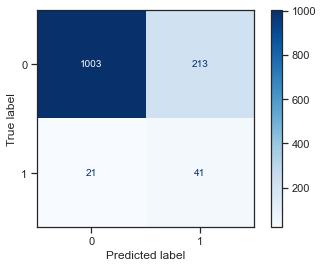

In [74]:
# Plot the confusion matrix
plot_confusion_matrix(adaboost_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [75]:
# Print classification report
print('Classification Report of Adaboost Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Adaboost Tuned Model:
              precision    recall  f1-score   support

           0       0.98      0.82      0.90      1216
           1       0.16      0.66      0.26        62

    accuracy                           0.82      1278
   macro avg       0.57      0.74      0.58      1278
weighted avg       0.94      0.82      0.86      1278



The adaboost tuned model got better: recal score became equal to 66%, while the number of false negatives dropped to 21. The adaboost tuned model was chosen for further analysis.

**Gradient Boosting Models**

In [76]:
# Build a baseline model and find the average of the cross-validated log loss
from sklearn.ensemble import GradientBoostingClassifier

gbt_baseline = GradientBoostingClassifier(random_state=42)
gbt_baseline.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

In [77]:
# Evaluate the model
preds = gbt_baseline.predict(X_test)
print("Gradient Boosting Baseline Model:")
print_metrics(y_test, preds)

Gradient Boosting Baseline Model:
Accuracy Score: 0.9311424100156495
Precision Score: 0.25925925925925924
Recall Score: 0.22580645161290322
F1 Score: 0.24137931034482757


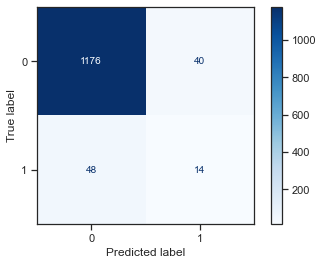

In [78]:
# Plot the confusion matrix
plot_confusion_matrix(gbt_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [79]:
# Print classification report
print('Classification Report of Gradient Boosting Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Gradient Boosting Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1216
           1       0.26      0.23      0.24        62

    accuracy                           0.93      1278
   macro avg       0.61      0.60      0.60      1278
weighted avg       0.93      0.93      0.93      1278



The performance of the gradient boosting baseline model was as follows: recall score constituted 23%, while the number of false negatives was equal to 48. The optimized model was then build and eveluated.

In [80]:
# Use the grid search to find the best learning rate
gbt = GradientBoostingClassifier(random_state=42)
param_grid = {'learning_rate' : [0.5, 0.7, 1.0]}
    
grid_search = GridSearchCV(estimator = gbt,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.5, 0.7, 1.0]})

In [81]:
# Print the best parameter
grid_search.best_params_

{'learning_rate': 0.5}

In [82]:
# Run the optimized model
gbt_tuned = GradientBoostingClassifier(
    random_state=42,
    learning_rate=0.5)
gbt_tuned.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(learning_rate=0.5, random_state=42)

In [83]:
# Evaluate the model
preds = gbt_tuned.predict(X_test)
print("Gradient Boosting Tuned Model:")
print_metrics(y_test, preds)

Gradient Boosting Tuned Model:
Accuracy Score: 0.931924882629108
Precision Score: 0.23404255319148937
Recall Score: 0.1774193548387097
F1 Score: 0.2018348623853211


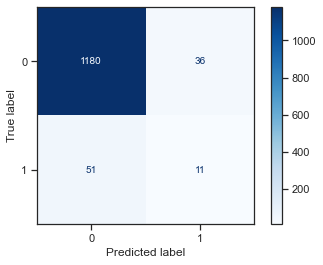

In [84]:
# Plot the confusion matrix
plot_confusion_matrix(gbt_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [85]:
# Print classification report
print('Classification Report of Gradient Boosting Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Gradient Boosting Tuned Model:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1216
           1       0.23      0.18      0.20        62

    accuracy                           0.93      1278
   macro avg       0.60      0.57      0.58      1278
weighted avg       0.92      0.93      0.93      1278



The gradient boosting tuned model performed a little worse than the baseline model: the recall score dropped to 18%, while the false negatives increased to 51. The baseline model was chosen.

**XGBoost Models**

In [86]:
# Build and run a baseline model
from xgboost import XGBClassifier

xgb_baseline = XGBClassifier(random_state=42)
xgb_baseline.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
# Evaluate the model
preds = xgb_baseline.predict(X_test)
print("XGBoost Baseline Model:")
print_metrics(y_test, preds)

XGBoost Baseline Model:
Accuracy Score: 0.9311424100156495
Precision Score: 0.175
Recall Score: 0.11290322580645161
F1 Score: 0.1372549019607843


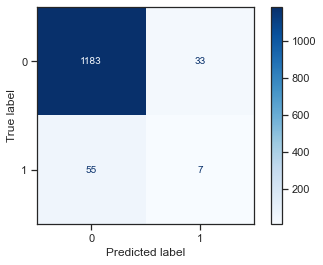

In [88]:
# Plot the confusion matrix
plot_confusion_matrix(xgb_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [89]:
# Print classification report
print('Classification Report of XGBoost Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of XGBoost Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1216
           1       0.17      0.11      0.14        62

    accuracy                           0.93      1278
   macro avg       0.57      0.54      0.55      1278
weighted avg       0.92      0.93      0.92      1278



The XGBoost baseline model was not great: the recall got equal to only 11%. The model was optimized to check for higher performance.

In [90]:
# Use the grid search to find the best hyperparameters
xgb = XGBClassifier(random_state=42)
param_grid = {'learning_rate' : [0.1, 0.2],
              'max_depth' : [6],
              'min_child_weight' : [1, 2],
              'subsample' : [0.5, 0.7],
              'n_estimators' : [100]}
    
grid_search = GridSearchCV(estimator = xgb,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [91]:
# Print the best hyperparameters
grid_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.7}

In [92]:
# Run the optimized model
xgb_tuned = XGBClassifier(random_state=42,
                          learning_rate=0.2,
                          max_depth=6,
                          min_child_weight=1,
                          n_estimators=100,
                          subsample=0.7)
xgb_tuned.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [93]:
# Evaluate the model
preds = xgb_tuned.predict(X_test)
print("XGBoost Tuned Model:")
print_metrics(y_test, preds)

XGBoost Tuned Model:
Accuracy Score: 0.9303599374021909
Precision Score: 0.11428571428571428
Recall Score: 0.06451612903225806
F1 Score: 0.08247422680412372


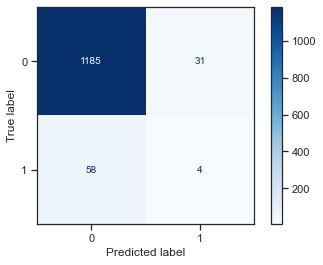

In [94]:
# Plot the confusion matrix
plot_confusion_matrix(xgb_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [95]:
# Print classification report
print('Classification Report of XGBoost Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of XGBoost Tuned Model:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1216
           1       0.11      0.06      0.08        62

    accuracy                           0.93      1278
   macro avg       0.53      0.52      0.52      1278
weighted avg       0.91      0.93      0.92      1278



The XGBoost tuned model perfromed worse: the recall became equal to only 6% now. The XGBoost baseline model was chosen.

**Naive Bayes Models**

In [96]:
# Build a baseline model 
from sklearn.naive_bayes import GaussianNB

naive_bayes_baseline = GaussianNB()
naive_bayes_baseline.fit(X_train_resampled, y_train_resampled)

GaussianNB()

In [97]:
# Evaluate the model
preds = naive_bayes_baseline.predict(X_test)
print("Naive Bayes Baseline Model:")
print_metrics(y_test, preds)

Naive Bayes Baseline Model:
Accuracy Score: 0.5774647887323944
Precision Score: 0.08070175438596491
Recall Score: 0.7419354838709677
F1 Score: 0.14556962025316456


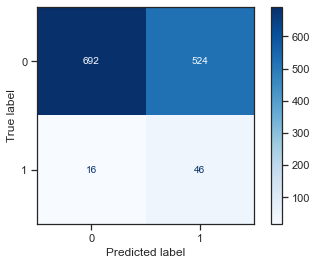

In [98]:
# Plot the confusion matrix
plot_confusion_matrix(naive_bayes_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [99]:
# Print classification report
print('Classification Report of Naive Bayes Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Naive Bayes Baseline Model:
              precision    recall  f1-score   support

           0       0.98      0.57      0.72      1216
           1       0.08      0.74      0.15        62

    accuracy                           0.58      1278
   macro avg       0.53      0.66      0.43      1278
weighted avg       0.93      0.58      0.69      1278



The naive bayes baseline model perfromed better than any model before. It got recall score of 74% with false negatives being equal to only 16. The model was still optimized to see if it could perform better.

In [100]:
# Find the best value for var_smoothing
nb = GaussianNB()
param_grid = {'var_smoothing' : np.logspace(0,-9, num=100)}
    
grid_search = GridSearchCV(estimator = nb,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [101]:
# Print the best parameter
grid_search.best_params_

{'var_smoothing': 1.5199110829529332e-05}

In [102]:
# Run the optimized model
nb_tuned = GaussianNB(var_smoothing=1.52e-05)
nb_tuned.fit(X_train_resampled, y_train_resampled)

GaussianNB(var_smoothing=1.52e-05)

In [103]:
# Evaliuate the model
preds = nb_tuned.predict(X_test)
print("Naive Bayes Tuned Model:")
print_metrics(y_test, preds)

Naive Bayes Tuned Model:
Accuracy Score: 0.7222222222222222
Precision Score: 0.10933333333333334
Recall Score: 0.6612903225806451
F1 Score: 0.18764302059496565


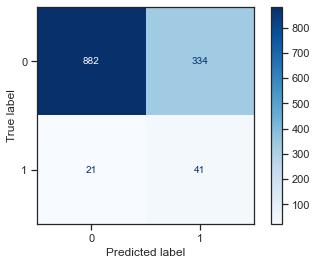

In [104]:
# Plot the confusion matrix
plot_confusion_matrix(nb_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [105]:
# Print classification report
print('Classification Report of Naive Bayes Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Naive Bayes Tuned Model:
              precision    recall  f1-score   support

           0       0.98      0.73      0.83      1216
           1       0.11      0.66      0.19        62

    accuracy                           0.72      1278
   macro avg       0.54      0.69      0.51      1278
weighted avg       0.93      0.72      0.80      1278



The performance of the naive bayes tuned model got worse. The recall decreased to 66%, while the number of false negatives increased to 21. It meant that the default parameters were much better in prediction whether a person would develop a stroke. The baseline model was chosen for further analysis.

In order to build knn and svm models, one more step was needed: the data had to be normalized. That had to be done for two reasons: 

- to avoid information "leaking" from the test set into the training set;
- to avoid having a larger impact that larger scaled features have on the distance between the points in distance-based classifiers.

Normalization (AKA Standardization or Scaling) means making sure that all of the data is represented at the same scale. The most common way to do this is to convert all numerical values to z-scores.

In [106]:
# Instantiate StandardScaler and transform the variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

**KNN Models**

In [107]:
# Build a baseline model
from sklearn.neighbors import KNeighborsClassifier

knn_baseline = KNeighborsClassifier()
knn_baseline.fit(X_train_scaled, y_train_resampled)

KNeighborsClassifier()

In [108]:
# Evaluate the model
preds = knn_baseline.predict(X_test_scaled)
print("KNN Baseline Model:")
print_metrics(y_test, preds)

KNN Baseline Model:
Accuracy Score: 0.9006259780907668
Precision Score: 0.06666666666666667
Recall Score: 0.08064516129032258
F1 Score: 0.072992700729927


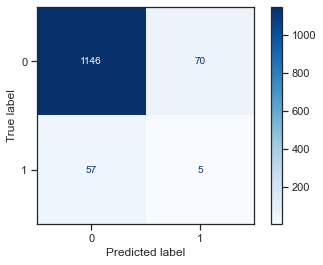

In [109]:
# Plot the confusion matrix
plot_confusion_matrix(knn_baseline, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [110]:
# Print classification report
print('Classification Report of KNN Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of KNN Baseline Model:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1216
           1       0.07      0.08      0.07        62

    accuracy                           0.90      1278
   macro avg       0.51      0.51      0.51      1278
weighted avg       0.91      0.90      0.91      1278



The knn baseline model didn't perform well. The recall score was very low adn equal to only 8%. The model was then optimized to find the best k value in order to increase teh recall.

In [111]:
# Change hyperparameter to see if the model performs any better
knn_first_model = KNeighborsClassifier(n_neighbors=75)
knn_first_model.fit(X_train_scaled, y_train_resampled)
preds = knn_first_model.predict(X_test_scaled)
print_metrics(y_test, preds)

Accuracy Score: 0.92018779342723
Precision Score: 0.24358974358974358
Recall Score: 0.3064516129032258
F1 Score: 0.2714285714285714


In [112]:
# Change hyperparameter and repeat the step above
knn_second_model = KNeighborsClassifier(n_neighbors=120)
knn_second_model.fit(X_train_scaled, y_train_resampled)
preds = knn_second_model.predict(X_test_scaled)
print_metrics(y_test, preds)

Accuracy Score: 0.9147104851330203
Precision Score: 0.22988505747126436
Recall Score: 0.3225806451612903
F1 Score: 0.2684563758389262


In [113]:
# Write the funstion that finds the best value for n_neighbors
def find_best_k(X_train, y_train, X_test, y_test, min_k=75, max_k=120):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        recall = recall_score(y_test, preds)
        if recall > best_score:
            best_k = k
            best_score = recall
    print("Best Value for k: {}".format(best_k))
    print("Recall: {}".format(best_score))

In [114]:
# Find the best value of k for the model
find_best_k(X_train_scaled, y_train_resampled, X_test_scaled, y_test)

Best Value for k: 115
Recall: 0.3225806451612903


In [115]:
# Run the optimized model
knn_tuned = KNeighborsClassifier(n_neighbors=115)
knn_tuned.fit(X_train_scaled, y_train_resampled)

KNeighborsClassifier(n_neighbors=115)

In [116]:
# Evaluate the optimized model
preds = knn_tuned.predict(X_test_scaled)
print("KNN Tuned Model:")
print_metrics(y_test, preds)

KNN Tuned Model:
Accuracy Score: 0.9115805946791862
Precision Score: 0.21978021978021978
Recall Score: 0.3225806451612903
F1 Score: 0.261437908496732


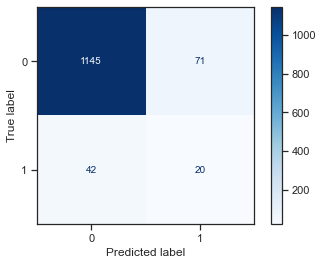

In [117]:
# Plot the confusion matrix
plot_confusion_matrix(knn_tuned, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [118]:
# Print classification report
print('Classification Report of KNN Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of KNN Tuned Model:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1216
           1       0.22      0.32      0.26        62

    accuracy                           0.91      1278
   macro avg       0.59      0.63      0.61      1278
weighted avg       0.93      0.91      0.92      1278



The knn tuned model performed much better: the recall score increased to 32%, while the number of false negatives dropped to 42. The knn tuned model was chosen.

**SVM Models**

In [119]:
# Build a baseline model
from sklearn.svm import SVC

svc_baseline = SVC(random_state=42, probability=True)
svc_baseline.fit(X_train_scaled, y_train_resampled)

SVC(probability=True, random_state=42)

In [120]:
# Evaluate the model
preds = svc_baseline.predict(X_test_scaled)
print("SVM Baseline Model:")
print_metrics(y_test, preds)

SVM Baseline Model:
Accuracy Score: 0.9272300469483568
Precision Score: 0.20754716981132076
Recall Score: 0.1774193548387097
F1 Score: 0.19130434782608696


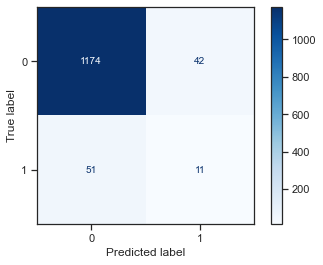

In [121]:
# Plot the confusion matrix
plot_confusion_matrix(svc_baseline, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [122]:
# Print classification report
print('Classification Report of SVC Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of SVC Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1216
           1       0.21      0.18      0.19        62

    accuracy                           0.93      1278
   macro avg       0.58      0.57      0.58      1278
weighted avg       0.92      0.93      0.92      1278



The svc baseline model had a recall of 18% and the number of false negatives was equal to 51. The model was optimized to check for the higer recall.

In [123]:
# Find the best hyperparameters
svc = SVC(random_state=42, probability=True)
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 'auto']}
    
grid_search = GridSearchCV(estimator = svc,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_scaled, y_train_resampled)

GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 'auto']})

In [124]:
# Print the best hyperparameters
grid_search.best_params_

{'C': 1, 'gamma': 1}

In [125]:
# Run the optimized model
svc_tuned = SVC(random_state=42, probability=True, C=1, gamma=1)
svc_tuned.fit(X_train_scaled, y_train_resampled)

SVC(C=1, gamma=1, probability=True, random_state=42)

In [126]:
# Evaluate the optimized model
svc = svc_tuned.predict(X_test_scaled)
print("SVM Tuned Model:")
print_metrics(y_test, preds)

SVM Tuned Model:
Accuracy Score: 0.9272300469483568
Precision Score: 0.20754716981132076
Recall Score: 0.1774193548387097
F1 Score: 0.19130434782608696


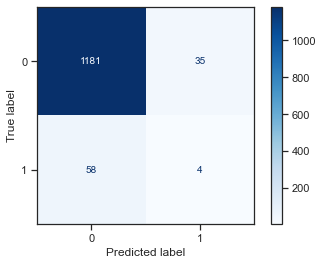

In [127]:
# Plot the confusion matrix
plot_confusion_matrix(svc_tuned, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [128]:
# Print classification report
print('Classification Report of SVC Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of SVC Tuned Model:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1216
           1       0.21      0.18      0.19        62

    accuracy                           0.93      1278
   macro avg       0.58      0.57      0.58      1278
weighted avg       0.92      0.93      0.92      1278



The svc tuned model didn't perfrom any better: the recall score didn't change and was equal to 18%, but because the number of false negatives got more (58), the svc baseline model was chosen for further analysis.

***

### Model Evaluation
Based on the findings, the graph with the best recall scores was plotted. It was found out that the best recall scores belonged to naive bayes baseline model and decision tree tuned model. The classification reports of the mentioned models were printed again.

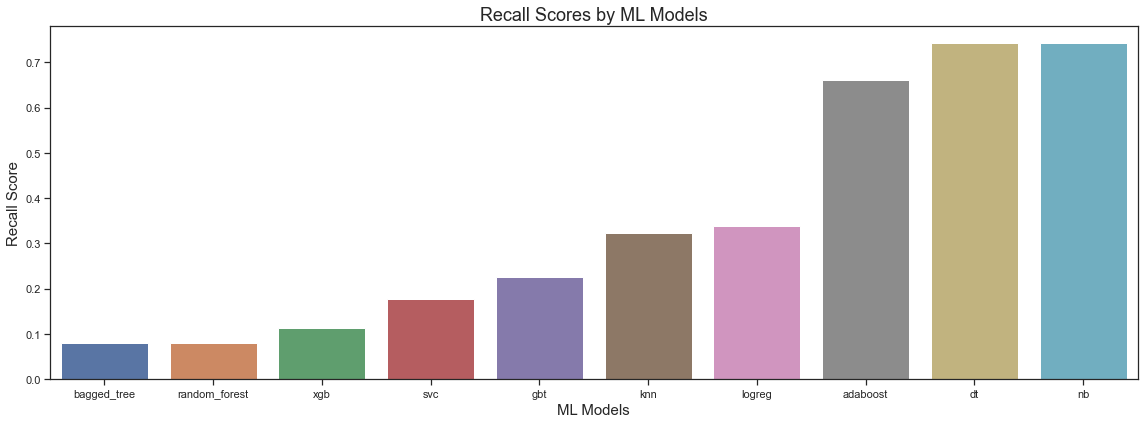

In [129]:
# Plot the graph with the best recall scores for different models
rec_logreg = recall_score(y_test, logreg_baseline.predict(X_test))
rec_dt = recall_score(y_test, dt_tuned.predict(X_test))
rec_bagged = recall_score(y_test, bagged_tree_baseline.predict(X_test))
rec_forest = recall_score(y_test, forest_tuned.predict(X_test))
rec_adaboost = recall_score(y_test, adaboost_tuned.predict(X_test))
rec_gbt = recall_score(y_test, gbt_baseline.predict(X_test))
rec_xgb = recall_score(y_test, xgb_baseline.predict(X_test))
rec_nb = recall_score(y_test, naive_bayes_baseline.predict(X_test))
rec_knn = recall_score(y_test, knn_tuned.predict(X_test_scaled))
rec_svc = recall_score(y_test, svc_baseline.predict(X_test_scaled))

recall = [rec_logreg, rec_dt, rec_bagged, rec_forest, rec_adaboost,
          rec_gbt, rec_xgb, rec_nb, rec_knn, rec_svc]
models = ['logreg', 'dt', 'bagged_tree', 'random_forest', 'adaboost',
          'gbt', 'xgb', 'nb', 'knn', 'svc']
recall_score = [round(num, 3) for num in recall]

df_recall = pd.DataFrame({'models': models, 'recall': recall_score}).sort_values(
    'recall', ascending=True)
plt.figure(figsize=(16,6))
sns.barplot(x='models', y='recall', data=df_recall)
plt.xlabel("ML Models", size=15)
plt.ylabel("Recall Score", size=15)
plt.title("Recall Scores by ML Models", size=18)
plt.tight_layout()
plt.savefig("recall.png", dpi=100)

In [131]:
# Print out the classification reports of the selected models
print('Classification Report of Naive Bayes Baseline Model:')
print(classification_report(y_test, naive_bayes_baseline.predict(X_test)))
print()
print('---------------')
print()
print('Classification Report of Decision Tree Tuned Model:')
print(classification_report(y_test, dt_tuned.predict(X_test)))

Classification Report of Naive Bayes Baseline Model:
              precision    recall  f1-score   support

           0       0.98      0.57      0.72      1216
           1       0.08      0.74      0.15        62

    accuracy                           0.58      1278
   macro avg       0.53      0.66      0.43      1278
weighted avg       0.93      0.58      0.69      1278


---------------

Classification Report of Decision Tree Tuned Model:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1216
           1       0.11      0.74      0.19        62

    accuracy                           0.70      1278
   macro avg       0.55      0.72      0.50      1278
weighted avg       0.94      0.70      0.78      1278



Based on the reports, it was determined that decision tree model performed better. The model correctly identifies if a person will have a stroke about 70% of the time (if compared to 58% of naive bayes model). Recall value of the model is 74%, meaning that if a person belongs to class 1 (having a stroke), there is about 70% chance that the model will correctly label this person as class 1.

Since the business really cares about avoiding 'false negatives' more than avoiding 'false positives', the decision threshold should be decreased, so recall can be increased.

In [200]:
# Write the function that will decrese the threshold
# if the model says there is >20% chance, we label it as class 1
def final_model_func(model, X):
    probs = model.predict_proba(X)[:,1]
    return [int(prob > 0.20) for prob in probs]

# Calculate predictions with adjusted threshold 
# Display proportions of predictions
print('Predictions with adjusted threshold for decision tree model:')
threshold_adjusted_probs_dt = pd.Series(final_model_func(dt_tuned, X_test))
threshold_adjusted_probs_dt.value_counts(normalize=True)

Predictions with adjusted threshold for decision tree model:


0    0.575117
1    0.424883
dtype: float64

Now we are predicting that everything over a 20% chance of being class 1 as class 1, which means that we'are classifying about 57.5% of the people as class 0 and 42% of the people as class 1.

In [201]:
print(classification_report(y_test, threshold_adjusted_probs_dt))

              precision    recall  f1-score   support

           0       0.99      0.60      0.74      1216
           1       0.10      0.85      0.18        62

    accuracy                           0.61      1278
   macro avg       0.54      0.73      0.46      1278
weighted avg       0.94      0.61      0.72      1278



The resulted metrics mean that we are able to identify 85% of the true positives (85% of the people that will develop stroke are identified). However, this comes at a cost: the overall accuracy is now 61% instead of 70%.

So we are classifying 42% of people as prone to stroke, even though fever than 5% of people are actually in that category. We do this in order to miss as few true positives as possible. This kind of model seems extreme, however, it might be useful if people that are prone to stroke can receive some kind of extra treatment or be monitored more often. The chosen model will allow to monitor 42% of the patients and successfully treat 85% of the ones that will develop stroke.

***

### Conclusions
The analysis of the stroke dataset resulted in the development of a pricing algorithm that can help real estate agencies and homeowners to sell houses. 